# Persona Validation Notebook

This notebook validates synthetic persona responses against ground truth data.

**Validation Process:**
1. Load synthetic responses (from `agent.py`)
2. Load ground truth data (US respondents)
3. Calculate validation metrics:
   - Mean Absolute Error (MAE)
   - Jensen-Shannon Divergence
   - Correlation
   - Standard Deviation Comparison

**Input:**
- `responses_{strategy}.jsonl` - Generated by agent.py
- `test/us_ground_truth.csv` - US ground truth data

**Output:**
- Validation metrics printed directly in notebook
- Comparison visualizations

## 1. Import Libraries

In [3]:
import json
import sys
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Add current directory to sys.path for test module imports
if str(Path.cwd()) not in sys.path:
    sys.path.insert(0, str(Path.cwd()))

from agent_utils import (
    load_responses,
    load_ground_truth_data,
    extract_test_columns,
    detect_api_provider
)

from test.test_utils import (
    parse_synthetic_responses,
    calculate_all_metrics,
    print_validation_results
)
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Configuration

Set the strategy to validate (random, ipip, or wpp)

In [34]:
# Set strategy and model to validate
STRATEGY = 'random'  # Options: 'random', 'ipip', 'wpp', 'no_persona'
MODEL = 'gemini-2.5-flash'  # e.g., 'gemini-2.5-flash', 'deepseek-chat', 'gpt-4o-mini'
RESPONSE_VERSION = 'v2'  # Options: 'v1', 'v2'

print(f"Strategy: {STRATEGY}")
print(f"Model: {MODEL}")
print(f"Response Version: {RESPONSE_VERSION}")

Strategy: random
Model: gemini-2.5-flash
Response Version: v2


## 3. Load Data

Load synthetic responses and ground truth data

In [35]:
# Detect API provider from model name
api_provider = detect_api_provider(MODEL)

# Load synthetic responses
responses_file = Path(f"responses_{RESPONSE_VERSION}/{STRATEGY}/{api_provider}/responses_{RESPONSE_VERSION}_{STRATEGY}_{MODEL}.jsonl")

if not responses_file.exists():
    print(f"❌ Responses file not found: {responses_file}")
    print(f"Please run: python agent.py --strategy {STRATEGY} --model {MODEL} --response-version {RESPONSE_VERSION}")
else:
    responses = load_responses(responses_file)
    print(f"✓ Loaded {len(responses)} synthetic responses from {responses_file.name}")
    
    # Parse responses into DataFrame using test_utils
    synthetic_df = parse_synthetic_responses(responses)
    print(f"✓ Parsed {len(synthetic_df):,} valid responses")
    
    # Load ground truth
    ground_truth_df = load_ground_truth_data()
    test_cols = extract_test_columns(ground_truth_df)
    
    print(f"\nSynthetic responses shape: {synthetic_df.shape}")
    print(f"Ground truth shape: {test_cols.shape}")

✓ Loaded 2000 synthetic responses from responses_v2_random_gemini-2.5-flash.jsonl

PARSING SUMMARY
Total responses:        2,000
Successfully loaded:    2,000 (100.0%)
Skipped (malformed):    0 (0.0%)

✓ Parsed 2,000 valid responses
✓ Loaded ground truth data: 8,753 records
  Columns: ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10']...

Synthetic responses shape: (2000, 51)
Ground truth shape: (8753, 50)


## 4. Calculate Validation Metrics

Compute MAE, JS Divergence, Correlation, and Std Deviation metrics

In [36]:
# Calculate all validation metrics using test_utils
metrics = calculate_all_metrics(synthetic_df, test_cols)

print("✓ Metrics calculated successfully")

✓ Metrics calculated successfully


## 5. Display Results

Print validation metrics and visualizations

In [38]:
# Print formatted validation results using test_utils
print_validation_results(metrics, f"{STRATEGY} ({MODEL})", len(synthetic_df), len(test_cols))

VALIDATION RESULTS - RANDOM (GEMINI-2.5-FLASH) STRATEGY

PERSONA CONSISTENCY METRICS
--------------------------------------------------------------------------------
Reverse-Item Coherence:          100.0% (5/5 traits)
Spearman Correlation (avg):      0.0201
Kendall Correlation (avg):       0.0223
Response Variance:               2.3077
Response Entropy:                1.5609

REVERSE-ITEM COHERENCE BY TRAIT
--------------------------------------------------------------------------------
E (Extraversion     ): r= -0.977 ✓ COHERENT
N (Neuroticism      ): r= -0.975 ✓ COHERENT
A (Agreeableness    ): r= -0.875 ✓ COHERENT
C (Conscientiousness): r= -0.929 ✓ COHERENT
O (Openness         ): r= -0.889 ✓ COHERENT

POPULATION SIMILARITY METRICS
--------------------------------------------------------------------------------
Mean Absolute Error (MAE):       0.3655
Jensen-Shannon Divergence:       0.0969
Mean Correlation:                0.9074

STATISTICAL TESTS
------------------------------------

## 6. Visualizations

Plot MAE distribution and mean comparison

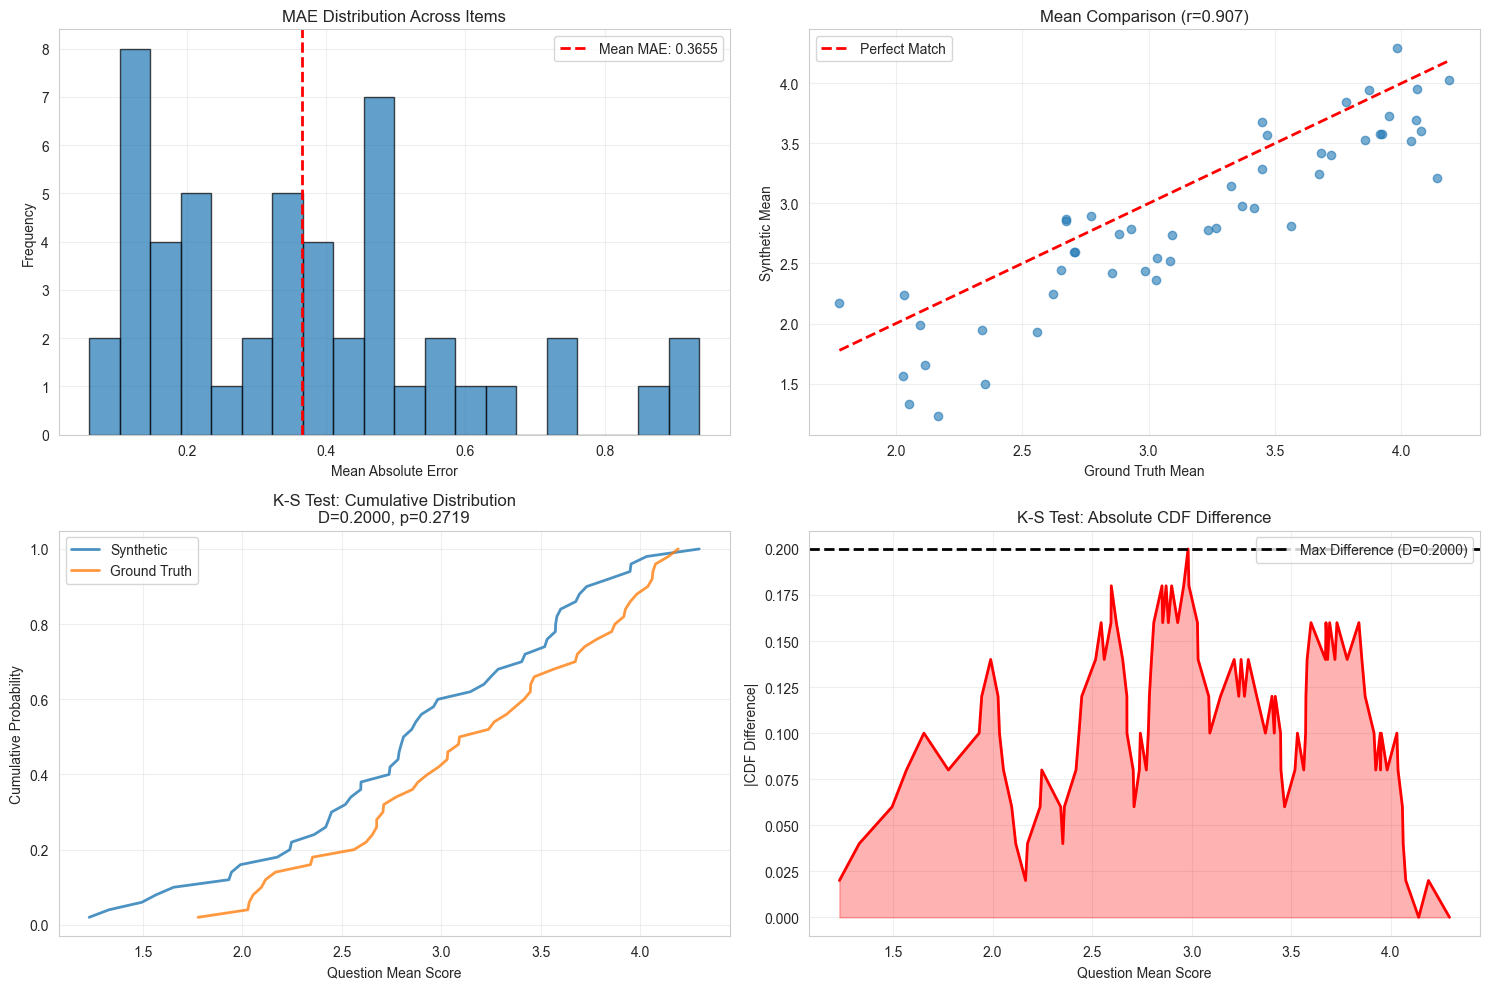

✓ Visualizations complete


In [39]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: MAE distribution
mae_values = list(metrics['mae_per_item'].values())
axes[0, 0].hist(mae_values, bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(metrics['mae_overall'], color='red', linestyle='--', linewidth=2, 
                label=f"Mean MAE: {metrics['mae_overall']:.4f}")
axes[0, 0].set_xlabel('Mean Absolute Error')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('MAE Distribution Across Items')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Synthetic vs Ground Truth Means
axes[0, 1].scatter(metrics['truth_means'], metrics['synth_means'], alpha=0.6)
axes[0, 1].plot([min(metrics['truth_means']), max(metrics['truth_means'])], 
             [min(metrics['truth_means']), max(metrics['truth_means'])], 
             'r--', linewidth=2, label='Perfect Match')
axes[0, 1].set_xlabel('Ground Truth Mean')
axes[0, 1].set_ylabel('Synthetic Mean')
axes[0, 1].set_title(f"Mean Comparison (r={metrics['correlation']:.3f})")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: K-S Test - Cumulative Distribution Functions
synth_sorted = np.sort(metrics['synth_means'])
truth_sorted = np.sort(metrics['truth_means'])
synth_cdf = np.arange(1, len(synth_sorted) + 1) / len(synth_sorted)
truth_cdf = np.arange(1, len(truth_sorted) + 1) / len(truth_sorted)

axes[1, 0].plot(synth_sorted, synth_cdf, label='Synthetic', linewidth=2, alpha=0.8)
axes[1, 0].plot(truth_sorted, truth_cdf, label='Ground Truth', linewidth=2, alpha=0.8)
axes[1, 0].set_xlabel('Question Mean Score')
axes[1, 0].set_ylabel('Cumulative Probability')
axes[1, 0].set_title(f"K-S Test: Cumulative Distribution\nD={metrics['ks_statistic']:.4f}, p={metrics['ks_p_value']:.4f}")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: K-S Test - Difference between CDFs
# Find common grid for interpolation
all_means = np.sort(np.concatenate([synth_sorted, truth_sorted]))
synth_cdf_interp = np.searchsorted(synth_sorted, all_means, side='right') / len(synth_sorted)
truth_cdf_interp = np.searchsorted(truth_sorted, all_means, side='right') / len(truth_sorted)
cdf_diff = np.abs(synth_cdf_interp - truth_cdf_interp)

axes[1, 1].fill_between(all_means, 0, cdf_diff, alpha=0.3, color='red')
axes[1, 1].plot(all_means, cdf_diff, color='red', linewidth=2)
axes[1, 1].axhline(metrics['ks_statistic'], color='black', linestyle='--', 
                   linewidth=2, label=f"Max Difference (D={metrics['ks_statistic']:.4f})")
axes[1, 1].set_xlabel('Question Mean Score')
axes[1, 1].set_ylabel('|CDF Difference|')
axes[1, 1].set_title('K-S Test: Absolute CDF Difference')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")